In [1]:
import numpy as np
import os
import re

import CDEF

import scipy.optimize
from scipy.optimize import root, Bounds

import time

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, NullFormatter

from build123d import export_stl, Sphere, Solid, Shell, Face, Wire, fillet
from ocp_vscode import show


def sphere_curve(radius, N=30000): 
    sphere = Sphere(radius)
    mesh = build123d_to_mesh(sphere)
    cloud = CDEF.stl_cloud(mesh, N, sequence='halton')
    curve = CDEF.scattering_mono(cloud, selfcorrelation=True)
    return curve

def bipyramid(fillet_radius, R, h, base_corners=5, center=(0,0,0), rotation=0.0):
    from build123d import Solid, Shell, Face, Wire, export_stl, fillet
    from scipy.spatial import ConvexHull
    import numpy as np

    def bipyramid_vertices(R, h, base_corners=5, center=(0,0,0), rotation=0.0):
        """Generate vertices of a bipyramid with a variable amount of base corners.

        Args:
            R (float): radius of the base.
            h (float): height of the apices above and below the base plane.
            center (tuple): (x, y, z) coordinates of the bipyramid center.
            rotation (float): rotation angle in radians applied to the base pentagon.

        Returns:
            List of 7 tuples [(x,y,z), ...] representing the bipyramid vertices.
        """
        cx, cy, cz = center
        vertices = []
        
        # 5 vertices of pentagonal base in XY plane with rotation
        for i in range(base_corners):
            angle = 2 * np.pi * i / base_corners + rotation
            x = cx + R * np.cos(angle)
            y = cy + R * np.sin(angle)
            z = cz
            vertices.append((x, y, z))
        
        # apex vertex at +h and -h
        vertices.append((cx, cy, cz + h))
        vertices.append((cx, cy, cz - h))
        
        return vertices

    vertices = bipyramid_vertices(R=R, h=h, base_corners=base_corners, center=center, rotation=rotation)

    # Create a convex hull from the vertices
    hull = ConvexHull(vertices).simplices.tolist()

    # Create faces from the vertex indices
    faces = []
    for face_vertex_indices in hull:
        corner_vertices = [vertices[i] for i in face_vertex_indices]
        faces.append(Face(Wire.make_polygon(corner_vertices)))

    # Create the solid from the Faces
    bipy = Solid(Shell(faces)).clean()
    if fillet_radius > 0:
        bipy = fillet(bipy.edges(), radius=fillet_radius)
    return bipy


def build123d_to_mesh(shape, tolerance=1e-3):
    all_tris = []
    for f in shape.faces():
        tess = f.tessellate(tolerance)
        # Case 1: tess returns (vertices, triangles)
        if isinstance(tess, tuple) and len(tess) == 2:
            vertices, triangles = tess
            # Convert each vertex to (x,y,z)
            coords = [ (v.X, v.Y, v.Z) if hasattr(v, "X") else tuple(v) for v in vertices ]
            for tri in triangles:
                all_tris.append([ coords[i] for i in tri ])
        # Case 2: tess returns list of triangles directly
        else:
            for tri in tess:
                # Convert each Vector to tuple if needed
                all_tris.append([ (v.X, v.Y, v.Z) if hasattr(v, "X") else tuple(v) for v in tri ])
    return np.array(all_tris, dtype=np.float64)


# Function to make 3D axes equal
def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale so that spheres appear as spheres."""
    limits = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    centers = np.mean(limits, axis=1)
    max_range = 0.5 * np.max(limits[:,1] - limits[:,0])
    for center, setter in zip(centers, [ax.set_xlim3d, ax.set_ylim3d, ax.set_zlim3d]):
        setter(center - max_range, center + max_range)


def next_folder(prefix, base_dir="."):
    """
    Find the next folder with prefix_xxxx in base_dir.
    If none exists, create prefix_0000.
    Otherwise, create prefix_<max+1> with leading zeros.
    """
    # Regex to match prefix_XXXX where XXXX are digits
    pattern = re.compile(rf"^{prefix}_(\d{{4}})$")
    
    max_num = -1
    for name in os.listdir(base_dir):
        match = pattern.match(name)
        if match:
            num = int(match.group(1))
            max_num = max(max_num, num)
    
    # Determine next number
    next_num = max_num + 1 if max_num >= 0 else 0
    folder_name = f"{prefix}_{next_num:04d}"
    folder_path = os.path.join(base_dir, folder_name)
    
    os.makedirs(folder_path, exist_ok=False)  # fail if it already exists
    return folder_path


def plot_fitresults(data, fit_result, unitscattering, distribution, N):
    #q-range of fit
    qvec = np.logspace(-3,0,1000)

    fit = CDEF.scattering_model(unitscattering, qvec, *fit_result.x, distribution)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex='col', sharey='row', gridspec_kw={'height_ratios':[3,1]})

    r = fit_result.x[1]
    r_bipy = 2*r / (1 + np.cos(np.pi/5))
    e_bipy = 2*r_bipy * np.sin(np.pi/5)

    ax[0].set_title(f'bipyramid mean side length = {e_bipy:.1f} nm, {N} pts')
    ax[0].set_xscale('log')
    ax[0].set_ylabel(r'$I$ / a. u.', fontsize=12)
    ax[0].set_yscale('log')

    #Frame limits
    ax[0].set_ylim([1e-1, 1e5])
    ax[0].set_xlim([3e-2, 1e0])

    ax[0].errorbar(data[:,0], data[:,1], 
                yerr = data[:,2], fmt='.', ecolor='k', 
                capsize= 2, capthick=1, alpha=0.6, markersize = 5, label = 'Experimental data', zorder=1)
    ax[0].loglog(fit[:,0], fit[:,1], label='Fit')

    ax[0].legend()

    #########################################
    ax[1].set_xlabel(r'$q$ / nm$^{-1}$', fontsize=12)
    ax[1].set_ylabel(r'$I$ / $I_{\mathrm{Fit}}$', fontsize=12)

    #Frame limits
    ax[1].set_ylim([0.85, 1.15])

    ax[1].errorbar(data[:, 0], data[:, 1]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
                yerr = data[:, 2]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
                fmt='.', ecolor='k', capsize= 2, capthick=1, alpha=0.6, markersize = 5, 
                label = 'Experimental data', zorder=1)

    ax[1].plot(fit[:,0], fit[:,1]/fit[:,1], label='Fit')

    plt.show()

    # fig.savefig(os.path.join("plots", f"pentagonal_bipyramid.png"))

718


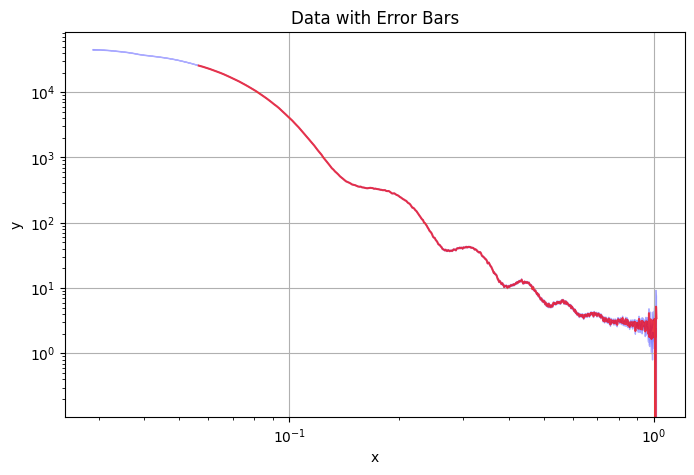

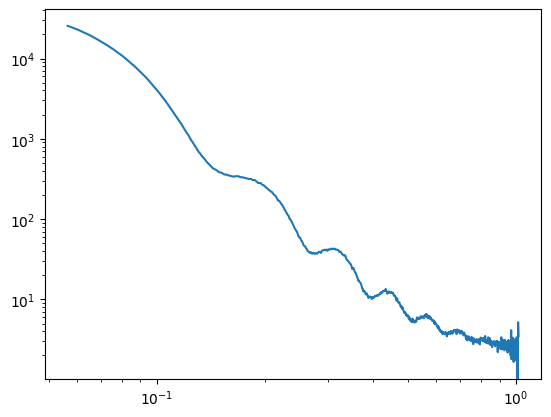

In [2]:
# Read measured data 

data = np.loadtxt("/messung/kmc/daten/2025/25_kw32/saxs_25_kw32/hdf_fcm_2025kw32_00097_Sample-Y_-8.0_Sample-X_44.7.dat")

x0 = 20
print(len(data))
x = data[:,0]
y = data[:,1]
yerr = data[:,3]

plt.figure(figsize=(8,5))
# plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=3, ecolor='red', markerfacecolor='blue', markersize=4)
# plt.plot(x, y, 'b-', label='y', alpha=0.3)
plt.fill_between(x, y - yerr, y + yerr, color='blue', alpha=0.3, label='uncertainty')
plt.plot(x[x0:], y[x0:], 'r-', label='y', alpha=0.7)
plt.xlabel("x")
plt.ylabel("y")
plt.yscale("log")
plt.xscale("log")
plt.title("Data with Error Bars")
plt.grid(True)
plt.show()

data = data[x0:,:]

fig, ax = plt.subplots()
ax.loglog(data[:,0], data[:,1])

# show(Sphere(1), port=3939)

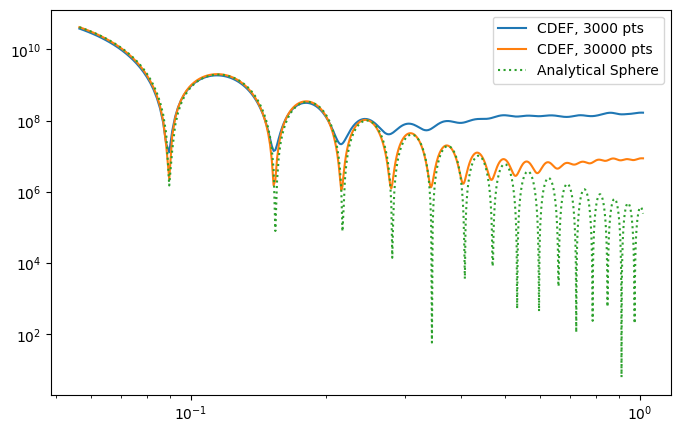

In [ ]:
%load_ext autoreload
%autoreload 2

import CDEF

N = 3000
distribution = 'lognormal'
N_C, mean, sigma, c0 =  30e-7, 50, 1e-8, 0
inital_guess = N_C, mean, sigma, c0

q = data[:,0]


tic = time.time()
unitscattering = sphere_curve(1, N)
polyscattering = CDEF.scattering_poly(unitscattering, q, mean, sigma, N, distribution=distribution)
qr = q * mean
analyticalsphere = np.column_stack((q, (3 * (np.sin(qr) - qr * np.cos(qr)) / (qr**3))**2))
analyticalsphere[:,1] *= (polyscattering[0,1] / analyticalsphere[0,1])

plt.figure(figsize=(8,5))
# plt.loglog(polyscattering[:,0], polyscattering[:,1], label='Poly Scattering')
plt.loglog(polyscattering[:,0], polyscattering[:,1], label=f'CDEF, {N} pts')
# plt.loglog(analyticalsphere[:,0], analyticalsphere[:,1], '--', label='Analytical Sphere')
# plt.legend()
# fit_result = scipy.optimize.minimize(CDEF.chi_squared, (inital_guess), args=(data, unitscattering, distribution), 
#                                      method = 'Powell', options={'disp' : True})
# toc = time.time()
# print('Calculation time = {} s'.format(toc-tic))
# print(f'fit results = {fit_result.x}')
# print(f'chi_squared = {CDEF.chi_squared(fit_result.x, data, unitscattering, distribution)}')


# plot_fitresults(data, fit_result, unitscattering, distribution, N)

N = 30000

tic = time.time()
unitscattering = sphere_curve(1, N)
polyscattering = CDEF.scattering_poly(unitscattering, q, mean, sigma, N, distribution=distribution)
# q = np.logspace(-2,1,1000)
# q = np.logspace(np.log10(5e-2),np.log10(3),1000)
qr = q * mean
analyticalsphere = np.column_stack((q, (3 * (np.sin(qr) - qr * np.cos(qr)) / (qr**3))**2))
analyticalsphere[:,1] *= (polyscattering[0,1] / analyticalsphere[0,1])

# plt.figure(figsize=(8,5))
# plt.loglog(polyscattering[:,0], polyscattering[:,1], label='Poly Scattering')
plt.loglog(polyscattering[:,0], polyscattering[:,1], label=f'CDEF, {N} pts')
plt.loglog(analyticalsphere[:,0], analyticalsphere[:,1], ':', label='Analytical Sphere')
plt.legend()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Calculation time = 0.24142980575561523 s
Calculation time = 0.3760247230529785 s
Calculation time = 0.7015624046325684 s
Calculation time = 2.5146331787109375 s
Calculation time = 11.644940614700317 s
Calculation time = 116.92897319793701 s


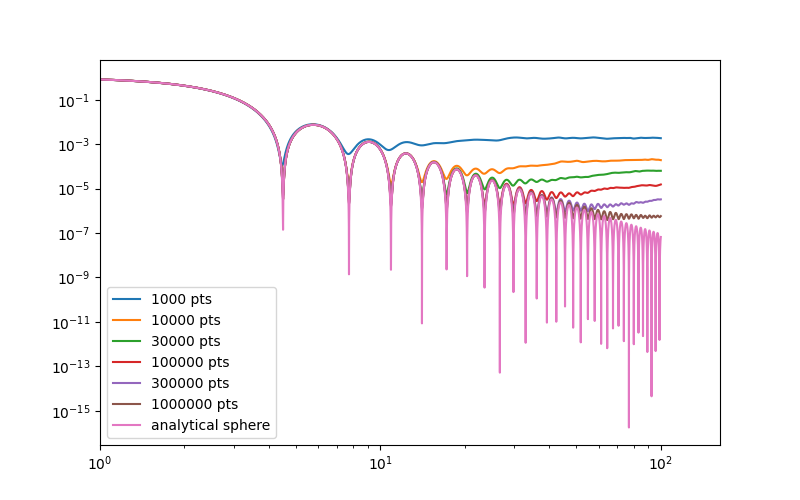

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

distribution = 'lognormal'
N_C, mean, sigma, c0 =  30e-7, 50, 1e-8, 0
inital_guess = N_C, mean, sigma, c0
# q = data[:,0]

plt.figure(figsize=(8,5))


for N in [1000, 10000, 30000, 100000, 300000, 1000000]:

    tic = time.time()
    unitscattering = sphere_curve(1, N)
    # polyscattering = CDEF.scattering_poly(unitscattering, q, mean, sigma, N, distribution=distribution)
    # qr = q * mean
    # analyticalsphere = np.column_stack((q, (3 * (np.sin(qr) - qr * np.cos(qr)) / (qr**3))**2))
    # analyticalsphere[:,1] *= (polyscattering[0,1] / analyticalsphere[0,1])
    plt.loglog(unitscattering[:,0], unitscattering[:,1], label=f'{N} pts')
    toc = time.time()
    print('Calculation time = {} s'.format(toc-tic))

q = unitscattering[:,0]
qr = q * 1
analyticalsphere = np.column_stack((q, (3 * (np.sin(qr) - qr * np.cos(qr)) / (qr**3))**2))
analyticalsphere[:,1] *= (unitscattering[0,1] / analyticalsphere[0,1])
plt.loglog(analyticalsphere[:,0], analyticalsphere[:,1], label=f'analytical sphere')
plt.xlim(xmin=1)
plt.legend()
plt.xlabel(r"$q \cdot R$")
plt.title("unit sphere scattering")

val_at_x = CDEF.chi_squared(fit_result.x, data, unitscattering, distribution)
print("Function at fit_result.x:", val_at_x)
print("fit_result.fun:", fit_result.fun)
print("Difference:", val_at_x - fit_result.fun)

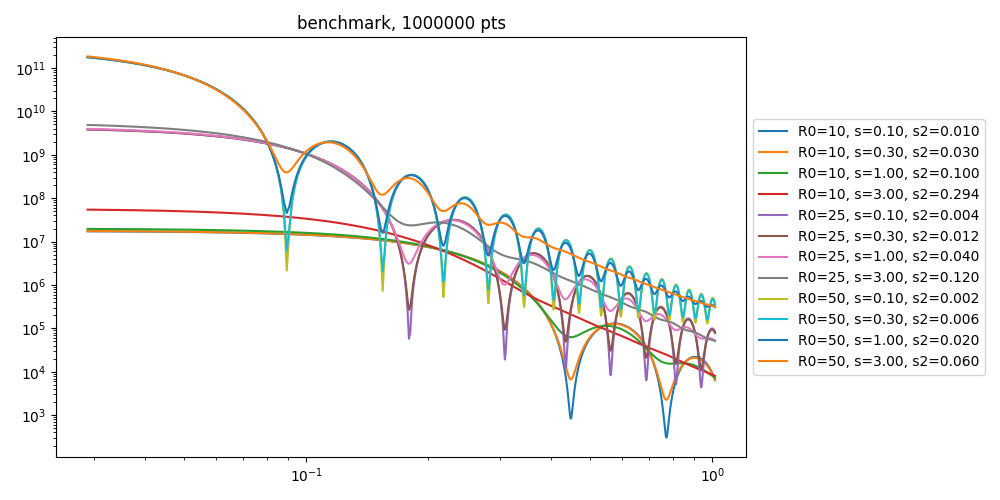

In [48]:
N = 1000000

distribution = 'lognormal'
N_C, mean, sigma, c0 =  30e-7, 50, 2, 0
inital_guess = N_C, mean, sigma, c0
sigma2 = np.sqrt(np.log(sigma**2/mean**2 + 1))

data = np.loadtxt("/messung/kmc/daten/2025/25_kw32/saxs_25_kw32/hdf_fcm_2025kw32_00097_Sample-Y_-8.0_Sample-X_44.7.dat")
q = data[:,0]
# q = unitscattering[:,0]

plt.figure(figsize=(10,5))

for mean in [10, 25, 50]:
    for sigma in [.1, .3, 1, 3]:

        sigma2 = np.sqrt(np.log(sigma**2/mean**2 + 1))
        # unitscattering = sphere_curve(1, N)
        polyscattering = CDEF.scattering_poly(unitscattering, q, mean, sigma, 1000, distribution=distribution)

        plt.loglog(polyscattering[:,0], polyscattering[:,1], label=f'R0={mean:.0f}, s={sigma:.2f}, s2={sigma2:.3f}')

        polyscattering = np.column_stack([polyscattering, np.sqrt(polyscattering[:, 1])])

        np.savetxt(
            f"benchmark_R{mean:.0f}_s{sigma:.1f}_s2{sigma2:.2g}.dat",
            polyscattering,
            fmt="%.6e\t%.6e\t%.6e",  # control formatting
            header="q\tI\tIerr",
            comments="#"                    # ensure header starts with '#'
        )

plt.title(f"benchmark, {N} pts")
plt.legend(
    loc="center left",           # position relative to the bounding box
    bbox_to_anchor=(1, 0.5)      # (x, y) coordinates relative to axes
)
plt.tight_layout()  

In [46]:
E = 50 #expectation value
VAR = 0.1**2 #variance
#parameters of normal-distributed log(particle size)
sigma2 = np.sqrt(np.log(VAR/E**2 + 1))
print(sigma2)

0.001999997999977578
